## 1. Definizione Imports

In [1]:
#roba generica
import numpy as np
from pathlib import Path
from PIL import Image
import copy

#gestione dataframe
import pandas as pd

#per grafici
import cv2 as cv
import matplotlib.pyplot as plt

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#usati da albumentations, contengono modelli e trasformazioni popolari
import torchvision
import torchvision.models as models
from torchvision.transforms.functional import to_grayscale
from torchvision.utils import make_grid

#modifica immagini (colorazione, blur, ecc ecc)
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

#metriche di bontà
#from sklearn.metrics import accuracy_score, roc_auc_score

#barre che mostrano il progresso
from fastprogress.fastprogress import master_bar, progress_bar

#reti preaddestrate di efficientnet
from efficientnet_pytorch import EfficientNet

#Modello personalizzato della nostra rete neurale
from ConcreteModel import ConcreteModel
from ConcreteModel import getModelInputSize as InputSize

## 2. Definizione Variabili

### Definizione Variabili Generiche

In [2]:
#VARIABILE DI TEST PER ESEGUIRE IL TAGLIO AL DATASET (IL TRAINING DIVENTA MOLTO LUNGO ALTRIMENTI, ED è GIUSTO COSì)
#SERVE SOLO X TESTARE IL FUNZIONAMENTO DI TUTTE LE FUNZIONI
CUT_TRAINING = True

#----- VARIABILI PER I PERCORSI DEL DATASET -----
#path per la classe negativa (senza crepe)
#ds_normal = Path('../../Dataset/Default/surface-crack-detection/Negative')
DS_PATH_NORMAL = Path('C:/Users/gianl/Downloads/ConcreteDataset/Normal')

#path per la classe positiva (con le crepe)
#ds_cracks = Path('../../Dataset/Default/surface-crack-detection/Positive')
DS_PATH_CRACKS = Path('C:/Users/gianl/Downloads/ConcreteDataset/Crack')

#path per la classe positiva (con le crepe)
#ds_cracks = Path('../../Dataset/Default/surface-crack-detection/Positive')
DS_PATH_SPALLING = Path('C:/Users/gianl/Downloads/ConcreteDataset/Spalling')

#path per il percorso in cui andrò a salvare i parametri del modello
#le estensioni standard sono .pt e .pth
MODEL_SAVE_PATH= Path('./Test_Model_Params.pt')
#------------------------------------------------

#----- VARIABILI PER IL DATAFRAME -----
#Dimensione del training set: valori accettabili da 0 a 1 (in genere si prende l'80/85%)
training_set_size = 0.80
validation_set_size = 0.15
test_set_size = 0.05
#LA SOMMA DI QUESTI 3 DEVE DARE 1

#seed per il random
rseed = 123

#variabili che indicano il nome delle due colonne del dataset
c_filepath = "filepath"
c_label = "label"
#--------------------------------------

#----- VARIABILI PER IL DATALOADER -----
#Valori di default che eseguono il caricamento in modalità non multi-threaded
#non modificare questi valori, decommentare le righe sotto e cambiare il valore la.
DL_TRAINING_N_WORKERS = 0
DL_VALIDATION_N_WORKERS = 0

#in caso di errori di pipeline broken, COMMENTARE QUESTE DUE RIGHE DI CODICE CON #
#DL_TRAINING_N_WORKERS = 4
#DL_VALIDATION_N_WORKERS = 3
#---------------------------------------

#PRINT VALORE VARIABILI
print("----- Paths -----")
print("Path Dataset Normal: " + str(DS_PATH_NORMAL))
print("Path Dataset Cracks: " + str(DS_PATH_CRACKS))
print("Path Model Params: " + str(MODEL_SAVE_PATH))
print("\n----- DataLoader -----")
print("Training # Workers: " + str(DL_TRAINING_N_WORKERS))
print("Validation # Workers: " + str(DL_VALIDATION_N_WORKERS))
print("\n----- Dataset Size -----")
print("Training set Dimension: " + str(training_set_size * 100) + "%")
print("Validation set Dimension: " + str(validation_set_size * 100) + "%")
print("Test set Dimension: " + str(test_set_size * 100) + "%")

----- Paths -----
Path Dataset Normal: C:\Users\gianl\Downloads\ConcreteDataset\Normal
Path Dataset Cracks: C:\Users\gianl\Downloads\ConcreteDataset\Crack
Path Model Params: Test_Model_Params.pt

----- DataLoader -----
Training # Workers: 0
Validation # Workers: 0

----- Dataset Size -----
Training set Dimension: 80.0%
Validation set Dimension: 15.0%
Test set Dimension: 5.0%


### Definizione Variabili della Rete

In [3]:
#BATCH SIZE, SE SI HA PIù RAM, SI PUò AUMENTARE PER VELOCIZZARE, ALTRIMENTI SI PUò RIDURRE SE SI HA POCA RAM
#Default: 64
batch_size = 256
BS = batch_size

#EPOCHE DI TRAINING (!!> 0) in genere si tiene 5-10-15, ecc ecc...
training_epoques = 5
TE = training_epoques

#LEARNING RATE
learning_rate = 1e-2
LR = learning_rate

#WEIGHT DECAY
weight_decay = 0.01
WD = weight_decay

# Flag for feature extracting.
# When False, we finetune the whole model
# When True we block the backbone and update only the new layers.
#           we update the backbone layers after the 'feature_training_from_layer' param value
feature_extract = True

# Se feature_extract = True, posso indicare da che layer della backbone eseguire il finetuning
# Se -1 il backbone non viene allenato
# Se 0 è come se avessimo metto feature_extract = False e dunque la rialleno da 0
feature_training_from_layer = -1

# Nome della rete EfficientNet da utilizzare
network_model_name = "efficientnet-b0"
#efficientnet-b0: 213 backbone params
#efficientnet-b1: 301 backbone params
#efficientnet-b2: 301 backbone params
#efficientnet-b4: 418 backbone params
# come consiglio conviene al massimo usare b3 (poi dopo i parametri aumentano di moltissimo e l'accuracy sale di poco)
# giustamente se si ha una buona gpu si può anche salire fino a b8 che è l'ultimo modello (attualmente: 17/12/2020)

#NUMERO DI CLASSI DA CLASSIFICARE (NORMALE, CREPA, FERRO CHE ESCE)
output_number_of_classes = 3
OC = output_number_of_classes

######################################################################################################
######################################################################################################
######################################################################################################
#LOSS FUNCTION
#https://pytorch.org/docs/stable/nn.html#loss-functions
loss_fn = nn.MultiLabelSoftMarginLoss()#MSELoss()
#MSELoss
#MultiLabelSoftMarginLoss
#MultiMarginLoss
######################################################################################################
######################################################################################################
######################################################################################################


#PRINT VALORE VARIABILI RETE
print("----- Network Training Params -----")
print("Batch size: " + str(BS))
print("Learning Rate: " + str(LR))
print("Weight Decay: " + str(WD))
print("Number of Classes: " + str(OC))
print("Selected Loss Function: " + str(loss_fn))

print("\n----- Finetuning -----")
if not feature_extract:
    print("Finetune not activated. Training from scratch of the whole Network")
else:
    if feature_training_from_layer == 0:
        print("Finetune not activated. Training from scratch of the whole Network")
    else:
        if feature_training_from_layer == -1:
            print("Finetune activated only on the new classifier")
        else:
            print("Finetune activated from backbone layer: ", str(feature_training_from_layer))

----- Network Training Params -----
Batch size: 256
Learning Rate: 0.01
Weight Decay: 0.01
Number of Classes: 3
Selected Loss Function: MultiLabelSoftMarginLoss()

----- Finetuning -----
Finetune activated only on the new classifier


## 3. Preparazione Data

### Caricamento dei dataset

In [4]:
train_data_normal = [(o, [1, 0, 0]) for o in DS_PATH_NORMAL.iterdir()]
train_data_cracks = [(o, [0, 1, 0]) for o in DS_PATH_CRACKS.iterdir()]
train_data_spalling = [(o, [0, 0, 1]) for o in DS_PATH_SPALLING.iterdir()]
train_data = []
train_data.extend(train_data_normal)
train_data.extend(train_data_cracks)
train_data.extend(train_data_spalling)

train_data = pd.DataFrame(train_data, columns=[c_filepath, c_label])

### Generazione Training, Validation e Test set

In [5]:
train_df, val_df, test_df = np.split(train_data.sample(frac=1, random_state=rseed),
                                 [
                                     int(training_set_size * len(train_data)), # Split TRAINING / (VALIDATION + TEST)
                                     int((training_set_size + validation_set_size) * len(train_data)) # Split VALIDATION / TEST
                                 ]
                                )

############################################################################
#TAGLIO IL DATASET SE INDICATO ALL'INIZIO (RAGIONI DI TEST DEL CODICE)
if CUT_TRAINING == True:
    print("Elements Training set Before Cutting: " + str(len(train_df)))
    print("Elements Validation set Before Cutting: " + str(len(val_df)))
    print("Elements Test set Before Cutting: " + str(len(test_df)))
    #DROP IN 3 PARTI
    #DROP CENTRALE
    train_df = train_df.drop(train_df.index[11000:35000])
    val_df = val_df.drop(val_df.index[800:3200])
    test_df = test_df.drop(test_df.index[400:2000])
    #DROP ALLA FINE
    train_df = train_df.drop(train_df.index[5000:14000])
    val_df = val_df.drop(val_df.index[2000:5000])
    test_df = test_df.drop(test_df.index[0:200])
    #DROP ALL'INIZIO
    train_df = train_df.drop(train_df.index[500:7500])
    val_df = val_df.drop(val_df.index[100:2332])
    test_df = test_df.drop(test_df.index[9:750])
    print("----------------------------------------")
############################################################################

#PRINT VALORE DIMENSIONI TRAINING SET E VALIDATION SET
print("Elements Training set: " + str(len(train_df)))
print("Elements Validation set: " + str(len(val_df)))
print("Elements Test set: " + str(len(test_df)))

Elements Training set Before Cutting: 40609
Elements Validation set Before Cutting: 7614
Elements Test set Before Cutting: 2539
----------------------------------------
Elements Training set: 609
Elements Validation set: 100
Elements Test set: 9


## 4. Visualizzazione dei 3 Dataset

In [6]:
#Numero di immagini da mostrare
plots = 4
#dimensioni delle immagini
#altezza
plots_height = 20
#larghezza
plots_width = 20

### Immagini di muri Normali (Senza crepe/spalling)

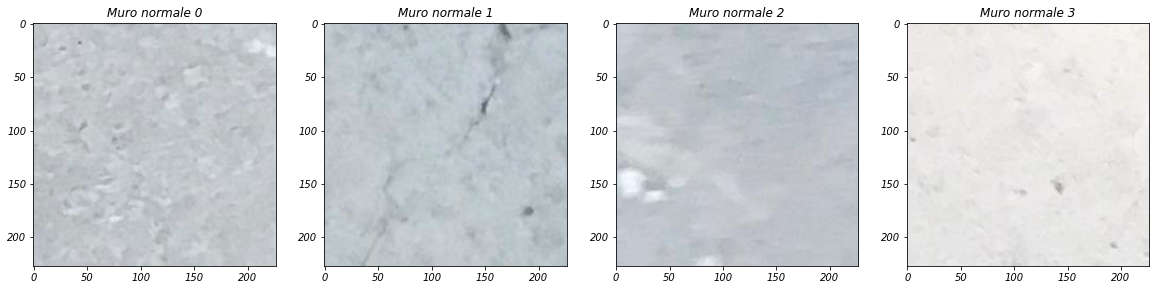

In [7]:
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(1, plots)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#INDEX PARTENZA GENERATO A CASO E POI MI PRENDO plots IMMAGINI DA QUEL PUNTO DA MANDARE A SCHERMO
starting_index = np.random.randint(len(train_data_normal) - (plots + 1))
#carico le immagini
for i in range(plots):
    a[i].imshow(cv.imread(str(train_data_normal[starting_index + i][0])))
    a[i].set_title("Muro normale " + str(i))

### Immagini di Muri con delle crepe

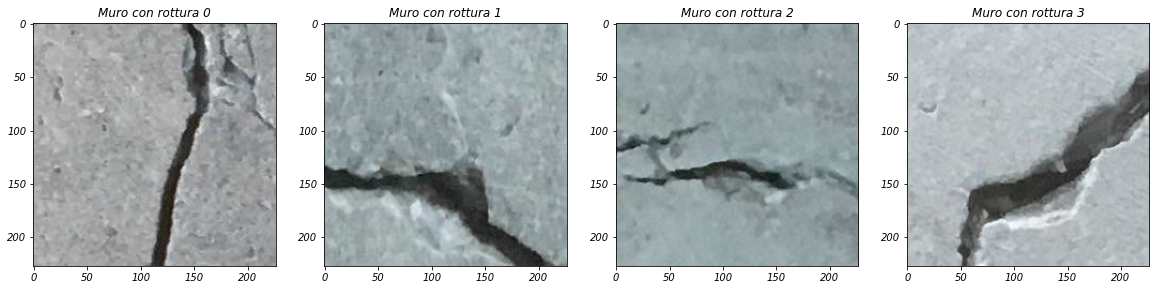

In [8]:
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(1, plots)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#INDEX PARTENZA GENERATO A CASO E POI MI PRENDO plots IMMAGINI DA QUEL PUNTO DA MANDARE A SCHERMO
starting_index = np.random.randint(len(train_data_cracks) - (plots + 1))
#carico le immagini
for i in range(plots):
    a[i].imshow(cv.imread(str(train_data_cracks[starting_index + i][0])))
    a[i].set_title("Muro con rottura " + str(i))

### Immagini di Muri con Spalling

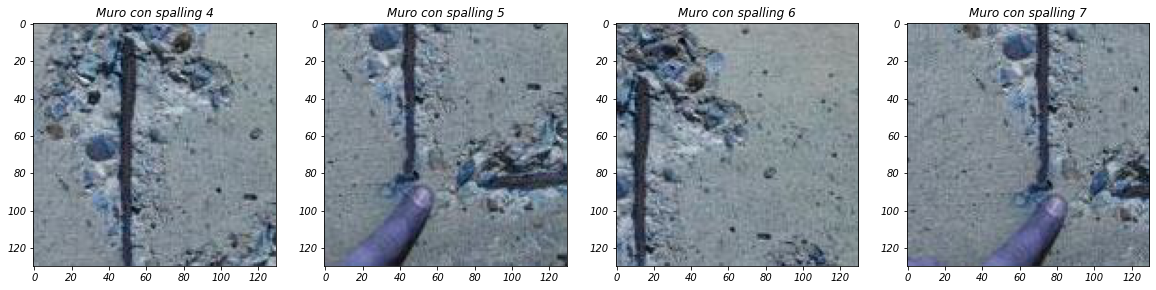

In [9]:
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(1, plots)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#INDEX PARTENZA GENERATO A CASO E POI MI PRENDO plots IMMAGINI DA QUEL PUNTO DA MANDARE A SCHERMO
starting_index = np.random.randint(len(train_data_spalling) - (plots + 1))
#carico le immagini
for i in range(0, plots):
    a[i].imshow(cv.imread(str(train_data_spalling[starting_index + i][0])))
    a[i].set_title("Muro con spalling " + str(plots + i))

## 5. Dataset Transformation

### Dataset personalizzato, applica delle trasformazioni alle immagini prese in input

In [10]:
#Questa classe permette di gestire il dataset di partenza, a cui però applico delle trasformazioni
#Se si vuole usare il dataset originario basta passare il dataframe di partenza.
class ConcreteDataset(Dataset):
    def __init__(self, df, transforms=None, is_test=False):
        self.df = df
        self.transforms = transforms
        self.is_test = is_test
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        #row = self.df.iloc[idx]
        img = Image.open(self.df.iloc[idx][c_filepath])
        
        if self.transforms:
            #when using albumation we have to pass data as dictionary to transforms.
            #The output after transformation is also a dictionary
            #we need to take the value from dictionary. That is why we are giving an image at the end.
            img = self.transforms(**{"image": np.array(img)})["image"]
        
        if self.is_test:
            return img
        else:
            cracks_tensor = torch.tensor(self.df.iloc[idx][c_label], dtype=torch.float32)
            return img, cracks_tensor

        
def get_data(train_df, val_df, test_df, train_tfms, val_test_tfms, bs):
    train_cds = ConcreteDataset(df = train_df, transforms = train_tfms)
    val_cds = ConcreteDataset(df = val_df, transforms = val_test_tfms)
    test_cds = ConcreteDataset(df = test_df, transforms = val_test_tfms)
    
    train_dl = DataLoader(dataset = train_cds, batch_size = bs, shuffle = True, num_workers = DL_TRAINING_N_WORKERS)
    val_dl = DataLoader(dataset = val_cds, batch_size = bs, shuffle = False, num_workers = DL_VALIDATION_N_WORKERS)
    test_dl = DataLoader(dataset = test_cds, batch_size = bs, shuffle = False, num_workers = DL_VALIDATION_N_WORKERS)
    return train_dl, val_dl, test_dl

### Definizioni delle trasformazioni da applicare

In [11]:
imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
#Mi prendo l'input size atteso della rete -> (width, height, channels)
size = InputSize()
#Trasformazioni per il set di training
train_tfms = A.Compose(
    [
        A.Cutout(p = 0.5),
        A.RandomRotate90(p = 0.5),
        A.Flip(p = 0.5),
        A.Resize(size[0], size[1]),
        ToTensor(normalize = imagenet_stats)
    ])

#Trasformazioni x il set di validation e di test
valid_test_tfms = A.Compose(
    [
        A.Resize(size[0], size[1]),
        ToTensor(normalize = imagenet_stats)
    ])

### Generazione dei Dataset nei Dataloader

In [12]:
train_dl, valid_dl, test_dl = get_data(train_df, val_df, test_df, train_tfms, valid_test_tfms, BS)

## 6. Training della rete

### Metodi usati per il training della rete

In [13]:
#Device in uso (cuda = GPU)
def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Metodo che ritorna una nuova copia del modello
def get_model(model_name='efficientnet-b0', lr=1e-5, wd=0.01, feature_extracting=False, feature_training_from = -1, opt_fn=torch.optim.AdamW, device=None, n_classes=1):
    device = device if device else get_device()
    model = ConcreteModel(eff_name = model_name, n_outs = n_classes)
    
    #Se feature_training_from = 0, rialleno tutto il backbone, dunque non imposto a False i requires_grad dei layer
    if feature_extracting and feature_training_from != 0:
        cont = 0
        for parameter in model.backbone.parameters():
            #Se feature_training_from = -1 allora congelo completamente il backbone
            #Se feature_training_from > 0, congelo tutti i layer che precedono questo valore, mentre gli altri li alleno
            if feature_training_from == -1 or cont < feature_training_from:
                parameter.requires_grad = False
            cont = cont + 1
                
    opt = opt_fn(model.parameters(), lr=lr, weight_decay=wd)
    model = model.to(device)
    return model, opt

def training_step(xb, yb, model, loss_fn, opt, device, scheduler):
    xb ,yb = xb.to(device), yb.to(device)
    opt.zero_grad()
    out = model(xb)
    loss = loss_fn(out,yb)
    loss.backward()
    opt.step()
    return loss.item()

def validation_step(xb, yb, model, loss_fn, device):
    xb, yb = xb.to(device), yb.to(device)
    out = model(xb)
    loss = loss_fn(out, yb)
    out = torch.relu(out)#torch.sigmoid(out)
    return loss.item(), out

### Metodo usato per il Fit della rete

In [14]:
def fit(epochs, model, train_dl, valid_dl, opt, loss_fn, device=None):
    
    device = device if device else get_device()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs)
    #val_rocs = []
    tloss = []
    vloss = []
    training_accuracy = []
    best_model = copy.deepcopy(model)
    best_accuracy = 0.0
    
    #Creating progress bar
    data_table = master_bar(range(epochs))
    data_table.write(['epoch', 'train_loss', 'valid_loss', 'accuracy(%)'],table=True)
    for epoch in data_table:    
        trn_loss, val_loss = 0.0, 0.0
        val_preds = np.zeros(len(valid_dl.dataset))
        val_targs = np.zeros((len(valid_dl.dataset), model.n_output_classes()))
        
        #Training
        model.train()
        #For every batch 
        for xb, yb in progress_bar(train_dl, parent = data_table):
            trn_loss += training_step(xb, yb, model, loss_fn, opt, device, scheduler)
        trn_loss /= data_table.child.total
        tloss.append(trn_loss)

        #Validation
        model.eval()
        with torch.no_grad():
            for i,(xb, yb) in enumerate(progress_bar(valid_dl, parent = data_table)):
                loss, out = validation_step(xb, yb, model, loss_fn, device)
                val_loss += loss
                bs = xb.shape[0]
                val_targs[i*bs : i*bs+bs] = yb.cpu().numpy()
                #Prendo dei vari tensori quello con valore massimo, che mi indicherà la classe
                val_preds[i*bs : i*bs+bs] = torch.max(out, 1).indices.cpu().numpy()
        
        #conto il numero di predizioni corrette
        correct = 0
        for target, index_pred in zip(val_targs, val_preds):
            if target[int(index_pred)] == 1:
                correct += 1
        
        val_accuracy = correct / len(val_preds) * 100
        training_accuracy.append(val_accuracy)
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = copy.deepcopy(model)
        
        
        val_loss /= data_table.child.total
        vloss.append(val_loss)

        data_table.write([epoch, f'{trn_loss:.4f}', f'{val_loss:.4f}', f'{val_accuracy:.2f}'], table=True)
        
        #PERMETTE DI FAR SCENDERE LEARNING RATE E WD
        #IN PRATICA DICE CHE è FINITA L'EPOCA
        scheduler.step()
        
    return best_model, tloss, vloss, training_accuracy

### Caricamento pesi della rete pre-allenata

In [15]:
%%time
model, opt = get_model(model_name=network_model_name, feature_extracting=feature_extract, feature_training_from=feature_training_from_layer, lr=LR, wd=WD, n_classes=OC)

cont = 0
for p in model.backbone.parameters():
    cont+=1
print("Model backbone 'params': ", cont)

Loaded pretrained weights for efficientnet-b0
----- ConcreteModel ----
New Classifier Stats: 
Input features 1° Linear:  1280
Input features 2° Linear:  640
Input features 3° Linear:  320
Output 3° Linear:  3
------------------------
Model backbone 'params':  213
Wall time: 284 ms


### Training effettivo della rete (fine-tuning)

In [16]:
%%time
model, train_loss, valid_loss, trains_accuracy = fit(TE, model, train_dl, valid_dl, opt, loss_fn)

epoch,train_loss,valid_loss,accuracy(%)
0,4.8311,1.8067,66.00
1,2.4555,0.8589,98.00
2,0.6654,3.4927,62.00
3,0.6878,2.2339,95.00
4,0.3857,1.0256,90.00


Wall time: 8min 26s


## 7. Plot Risultati del Training

### Plot Training Loss

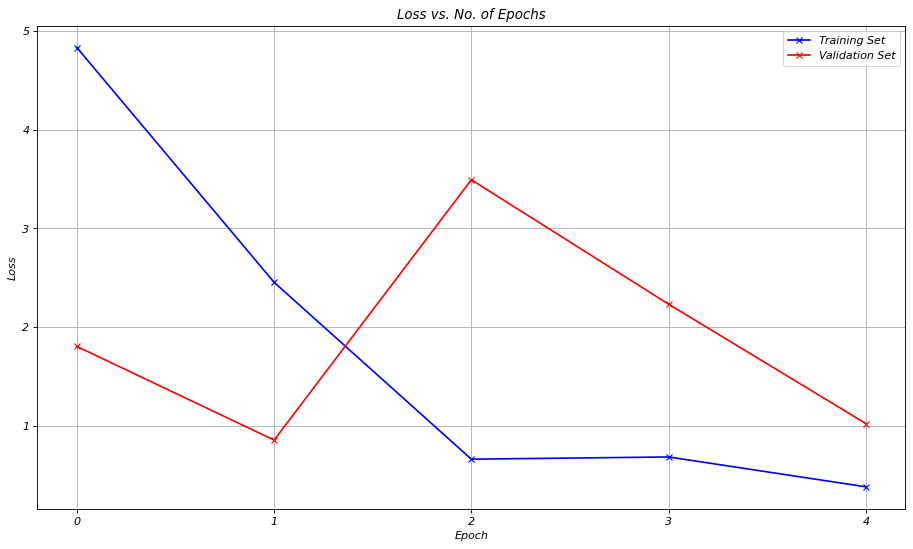

In [17]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, '-bx')
plt.plot(valid_loss, '-rx')
plt.xlabel('Epoch')
plt.xticks(range(0, TE))
plt.ylabel('Loss')
plt.legend(['Training Set', 'Validation Set'])
plt.title('Loss vs. No. of Epochs');
plt.grid()

### Plot Training Accuracy

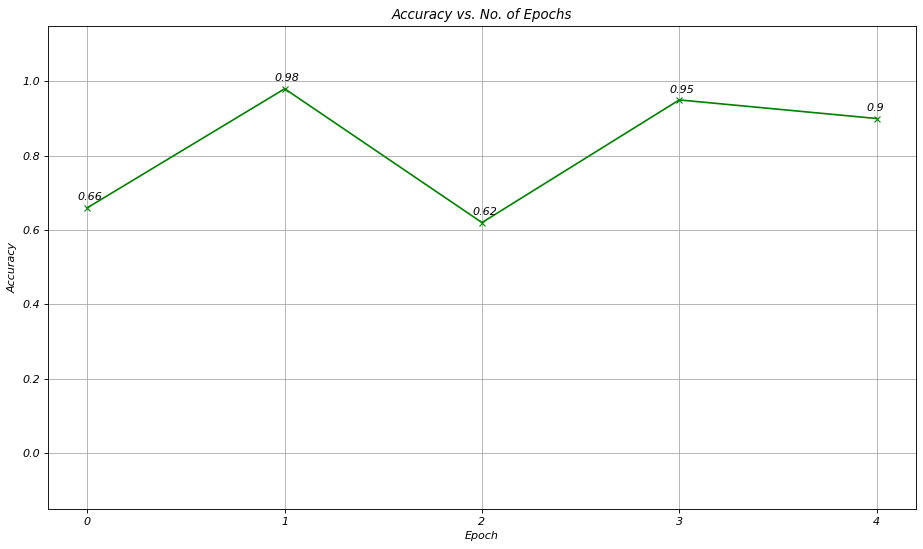

In [18]:
#NORMALIZZO DA 0 A 1 E TOGLIO I NUMERI DOPO 2 POSIZIONI NELLA VIRGOLA
trains_accuracy_normalized = np.array(np.round(trains_accuracy, 2)) / 100
#FIGURA
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(trains_accuracy_normalized, '-gx')
plt.xlabel('Epoch')
plt.xticks(range(0, TE))
plt.ylabel('Accuracy')
plt.ylim(-0.15, 1.15)
plt.title('Accuracy vs. No. of Epochs');
plt.grid()
#NUMERINI SULLA GRIGLIA
for x,y in zip(trains_accuracy_normalized, range(0, len(trains_accuracy_normalized))):
    plt.annotate(str(x),xy=(y-0.05 ,x + 0.02))

## 8. Test Della rete Sul Test Set

9


torch.return_types.max(
values=tensor([44.6370, 26.1627, 25.6546, 35.1460, 22.7627, 17.5900, 22.7567, 33.3462,
        19.5488]),
indices=tensor([2, 2, 1, 1, 1, 0, 1, 1, 2]))
Accuracy:  100.00%


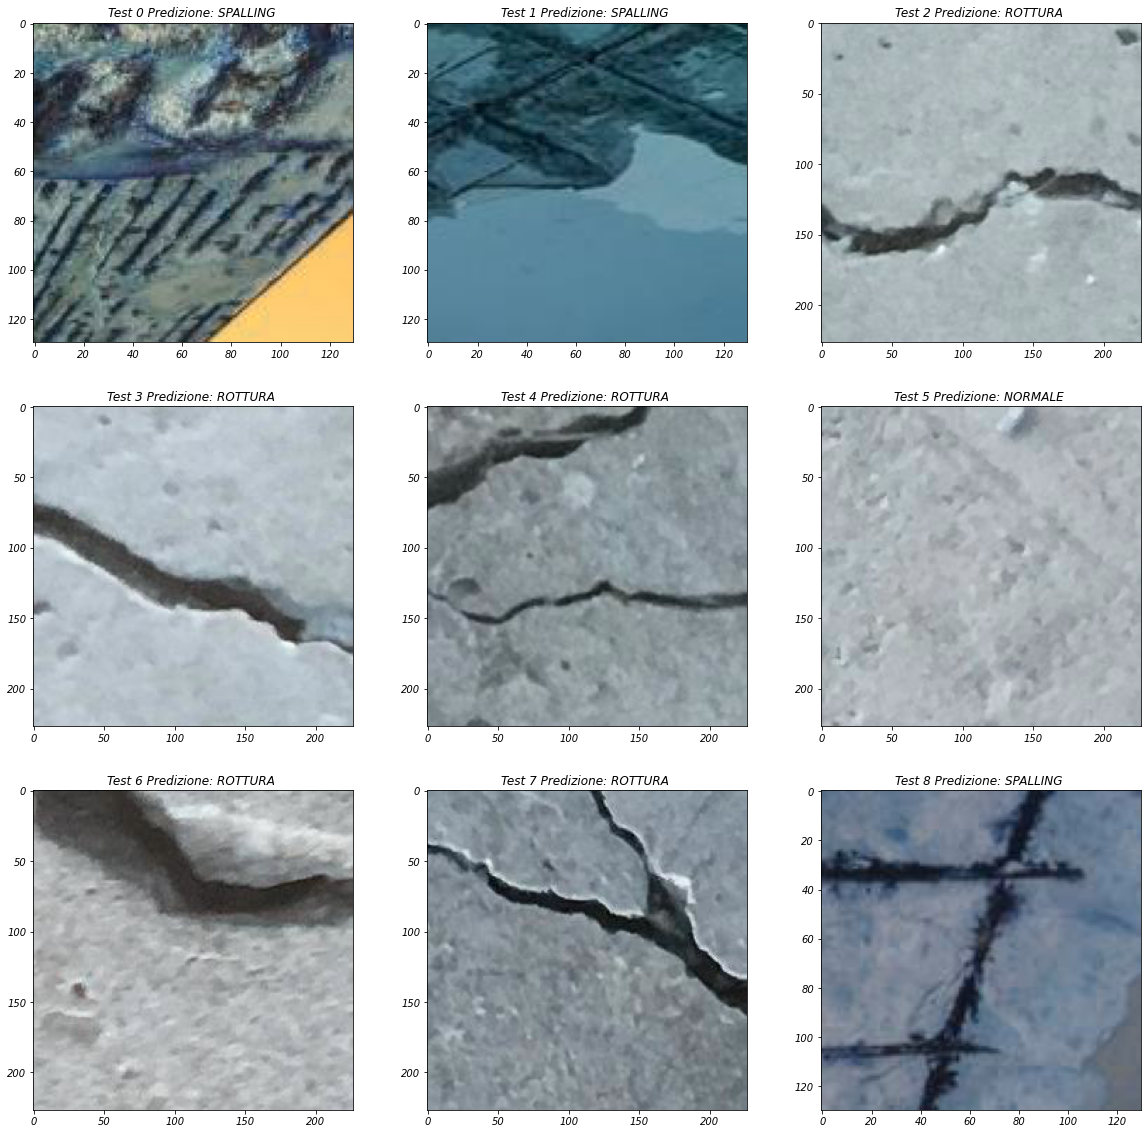

In [19]:
mtest = len(test_df)
print(mtest)

#imposto la rete in modalità evaluate
model.eval()
with torch.no_grad():
    for xb, yb in progress_bar(test_dl):
        out = model(xb)

#Trasformo il tensore risultato, prendendo il valore maggiore che mi indica la classe
results = torch.max(out, 1)
print(results)
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(3, 3)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#carico le immagini
cont = 0
for i in range(0, 3):
    for j in range (0, 3):
        predicted_class = int(results.indices[cont].item())
        a[i][j].imshow(cv.imread(str(test_df.iloc[cont][c_filepath])))
        if predicted_class == 0:
            a[i][j].set_title("Test " + str(cont) + " Predizione: NORMALE ")
        else:
            if predicted_class == 1:
                a[i][j].set_title("Test " + str(cont) + " Predizione: ROTTURA ")
            else:
                a[i][j].set_title("Test " + str(cont) + " Predizione: SPALLING ")
        cont += 1
correct = 0
for target, index_pred in zip(test_df[c_label], results.indices.cpu().numpy()):
    if target[int(index_pred)] == 1:
        correct += 1
print("Accuracy: ", f'{correct / len(results.indices.numpy()) * 100:.2f}' + "%")

## 9. Salvataggio del Modello

### Print delle informazioni del Modello e dell'Optimizer

In [20]:
# DECOMMENTARE I 2 CICLI FOR E LE CORRISPETTIVE PRINT PER MOSTRARE LE INFORMAZIONI

#Print informazioni del modello
print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("\n\n##################################################  ##################################################")
print("##################################################  ##################################################\n\n")
#Print informazioni dell'ottimizzatore
print("Optimizer's state_dict:")
#for var_name in opt.state_dict():
#    print(var_name, "\t", opt.state_dict()[var_name])

Model's state_dict:


##################################################  ##################################################
##################################################  ##################################################


Optimizer's state_dict:


### Salvataggio del Modello

In [21]:
#Salvataggio
torch.save(model.state_dict, MODEL_SAVE_PATH)